### Generating human faces with Adversarial Networks
![img](https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg)

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

 Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
import sys
sys.path.append("..")
import grading
import download_utils


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

In [21]:


from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import load_lfw_dataset 
data,attrs = load_lfw_dataset(dimx=36,dimy=36)
print(data[0])
#preprocess faces
data = np.float32(data)
 #scale to between -1 and 1
print(data[0])
IMG_SHAPE = data.shape[1:]

HBox(children=(IntProgress(value=0, max=13233), HTML(value='')))


[[[122 115 106]
  [ 96  88  74]
  [ 95  82  64]
  ..., 
  [162 129  86]
  [185 158 113]
  [174 153 106]]

 [[116 106  94]
  [ 92  80  63]
  [ 95  80  56]
  ..., 
  [146 112  69]
  [180 151 107]
  [178 156 109]]

 [[101  87  70]
  [ 91  75  53]
  [ 97  77  48]
  ..., 
  [142 107  65]
  [168 138  94]
  [180 156 110]]

 ..., 
 [[ 72  64  30]
  [ 48  38  16]
  [ 32  19  10]
  ..., 
  [166 125  84]
  [140 106  64]
  [128 100  56]]

 [[ 76  67  33]
  [ 55  44  20]
  [ 36  25  12]
  ..., 
  [164 123  81]
  [139 108  63]
  [134 107  61]]

 [[ 81  71  35]
  [ 60  51  22]
  [ 38  30  11]
  ..., 
  [150 112  68]
  [135 104  58]
  [140 116  68]]]
[[[ 122.  115.  106.]
  [  96.   88.   74.]
  [  95.   82.   64.]
  ..., 
  [ 162.  129.   86.]
  [ 185.  158.  113.]
  [ 174.  153.  106.]]

 [[ 116.  106.   94.]
  [  92.   80.   63.]
  [  95.   80.   56.]
  ..., 
  [ 146.  112.   69.]
  [ 180.  151.  107.]
  [ 178.  156.  109.]]

 [[ 101.   87.   70.]
  [  91.   75.   53.]
  [  97.   77.   48.]
  ...,

In [20]:
data=(data-127.5)/127.5
print(data[0])

[[[-0.04313726 -0.09803922 -0.16862746]
  [-0.24705882 -0.30980393 -0.41960785]
  [-0.25490198 -0.35686275 -0.49803922]
  ..., 
  [ 0.27058825  0.01176471 -0.32549021]
  [ 0.4509804   0.23921569 -0.11372549]
  [ 0.36470589  0.2        -0.16862746]]

 [[-0.09019608 -0.16862746 -0.26274511]
  [-0.27843139 -0.37254903 -0.50588238]
  [-0.25490198 -0.37254903 -0.56078434]
  ..., 
  [ 0.14509805 -0.12156863 -0.45882353]
  [ 0.41176471  0.18431373 -0.16078432]
  [ 0.39607844  0.22352941 -0.14509805]]

 [[-0.20784314 -0.31764707 -0.4509804 ]
  [-0.28627452 -0.41176471 -0.58431375]
  [-0.23921569 -0.39607844 -0.62352943]
  ..., 
  [ 0.11372549 -0.16078432 -0.49019608]
  [ 0.31764707  0.08235294 -0.26274511]
  [ 0.41176471  0.22352941 -0.13725491]]

 ..., 
 [[-0.43529412 -0.49803922 -0.7647059 ]
  [-0.62352943 -0.7019608  -0.87450981]
  [-0.74901962 -0.8509804  -0.92156863]
  ..., 
  [ 0.3019608  -0.01960784 -0.34117648]
  [ 0.09803922 -0.16862746 -0.49803922]
  [ 0.00392157 -0.21568628 -0.56078

(13143, 36, 36, 3)


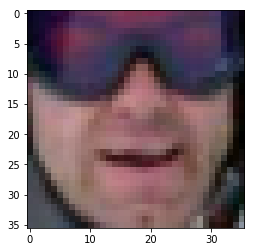

In [4]:
#print random image
print(data.shape)

a=np.random.randint(data.shape[0])

img=(data[a]+1.)/2. #scale to between 0 and 1 for display
plt.imshow(img,cmap='gray',interpolation=None)


# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [33]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

import keras
from keras.models import Sequential
from keras import layers as L
from keras.layers import LeakyReLU
from keras import backend as K
K.set_learning_phase(1)

In [34]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8,kernel_initializer='he_normal'))
generator.add(LeakyReLU(alpha=0.2))

generator.add(L.Reshape((8,8,10)))
print(generator.output_shape)
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),kernel_initializer='he_normal'))
generator.add(LeakyReLU(alpha=0.2))
print(generator.output_shape)
generator.add(L.Dropout(0.2))

generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),kernel_initializer='he_normal'))
print(generator.output_shape)
generator.add(LeakyReLU(alpha=0.2))
generator.add(L.Dropout(0.1))

generator.add(L.Conv2DTranspose(32,kernel_size=(5,5),strides=2,padding='same',kernel_initializer='he_normal'))
print(generator.output_shape)
generator.add(LeakyReLU(alpha=0.2))


generator.add(L.Conv2DTranspose(32,kernel_size=3,kernel_initializer='he_normal'))
print(generator.output_shape)
generator.add(L.Dropout(0.1))
generator.add(LeakyReLU(alpha=0.2))

generator.add(L.Conv2DTranspose(32,kernel_size=3,kernel_initializer='he_normal'))
print(generator.output_shape)
generator.add(LeakyReLU(alpha=0.1))

generator.add(L.Conv2DTranspose(32,kernel_size=3,kernel_initializer='he_normal'))
generator.add(LeakyReLU(alpha=0.1))
print(generator.output_shape)
#generator.add(L.Dropout(0.3))                                                                                                                                                                        \
                                                                                                                                                                                                       

generator.add(L.Conv2D(3,kernel_size=3,activation='tanh',kernel_initializer='glorot_uniform'))
print(generator.output_shape)

generator.summary()





(None, 8, 8, 10)
(None, 12, 12, 64)
(None, 16, 16, 64)
(None, 32, 32, 32)
(None, 34, 34, 32)
(None, 36, 36, 32)
(None, 38, 38, 32)
(None, 36, 36, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 640)               164480    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 640)               0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 12, 12, 64)        16064     
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 12, 12, 64)        0   

In [6]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [35]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(32,(3,3),strides=2,padding='same',kernel_initializer='he_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
print(discriminator.output_shape)
discriminator.add(L.Conv2D(32,(3,3),strides=2,padding='same',kernel_initializer='he_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
discriminator.add(L.Conv2D(64,(3,3),strides=2,padding='same',kernel_initializer='he_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
print(discriminator.output_shape)
discriminator.add(L.AveragePooling2D((2,2),padding='same'))
print(discriminator.output_shape)
discriminator.add(L.Conv2D(128,(3,3),padding='same',kernel_initializer='he_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
print(discriminator.output_shape)
discriminator.add(L.Flatten())
print(discriminator.output_shape)
discriminator.add(L.Dense(256,activation='tanh',kernel_initializer='glorot_uniform'))
print(discriminator.output_shape)
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))
discriminator.summary()



(None, 18, 18, 32)
(None, 5, 5, 64)
(None, 3, 3, 64)
(None, 3, 3, 128)
(None, 1152)
(None, 256)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 36, 36, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 18, 18, 32)        896       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 5, 64)          18496     
______________________________________________

In [55]:
generator.load_weights('generator_weights3_80000.h5')
discriminator.load_weights('discriminator_weights3_80000.h5')

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/cw4nognxx/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [33]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)
print(logp_real.shape)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)
print(logp_gen.shape)

(?, 2)
(?, 2)


In [34]:
########################
#discriminator training#
########################
surity1=np.random.uniform(0.8,1.15)
surity2=np.random.uniform(-1.0,0.2)
d_loss = -tf.reduce_mean(surity1*logp_real[:,1] + (1-surity2)*logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#tf.summary.scalar('disc_loss', d_loss)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [35]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean((logp_gen[:,1]))

#tf.summary.scalar('gen_loss', g_loss)
gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [36]:
#merged = tf.summary.merge_all()
#train_writer = tf.summary.FileWriter('./logs',s.graph)

s.run(tf.global_variables_initializer())

### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [11]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    #print(images[np.where(images<-1 or  images>1)])
    #print(np.max(images[0]),np.min(images[0]),images[0])
    images=(images+1.)/2.
    #print(np.max(images[0]),np.min(images[0]),images[0])
    
    if np.var(images)!=0:
        images = images.clip(0.,1.)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1],bins=80)
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1],bins=80)
    plt.legend(loc='best')
    plt.show()

In [38]:
for _ in range(10):
    print(sample_noise_batch(1))

[[  2.37910137e-01  -1.47796059e+00  -2.05016151e-01  -8.74108911e-01
    1.63154408e-01   4.96003687e-01  -7.35175610e-02   4.51916128e-01
    4.81175274e-01   6.49108768e-01  -1.40850479e-02   1.26360054e-03
    7.03763425e-01   1.31277740e+00   1.85976470e+00   2.12947801e-01
   -1.64440408e-01  -1.20369542e+00   1.00999784e+00   9.39261541e-02
    3.34284514e-01  -6.27999961e-01  -7.91237354e-01   4.08543736e-01
   -1.95211191e-02  -1.23260403e+00   1.25358069e+00   1.17387056e+00
    3.13700467e-01  -7.64747322e-01  -1.60530472e+00  -1.41289933e-02
    1.30048886e-01   1.07682979e+00  -4.30537701e-01   6.70608222e-01
    1.07466269e+00  -6.49029851e-01   1.88720667e+00  -1.51014864e+00
    1.72150701e-01  -8.33417773e-01  -3.20487559e-01  -9.59589124e-01
   -4.04096723e-01   3.83573741e-01  -3.84877831e-01   1.57597756e+00
    7.63542295e-01   1.60147727e+00  -3.81934583e-01  -2.73919404e-01
   -3.77642214e-01   1.79950297e+00  -1.15798377e-01  -9.48974073e-01
    5.55433452e-01  

In [ ]:
#hid_layers=[]
#for layer_idx in range(len(generator.layers)):
#    if isinstance(generator.layers[layer_idx], L.Conv2DTranspose) or isinstance(generator.layers[layer_idx], L.Dense):
#        hid_layers.append(K.function([generator.layers[0].input],[generator.layers[layer_idx].output]))    
#inp=np.random.normal(size=(1, 256)).astype('float32')

#for layer in hid_layers:
 #   print(layer([inp])[0])

In [ ]:
#for layer_idx in range(len(generator.layers)):
#    if isinstance(generator.layers[layer_idx], L.Conv2DTranspose) or isinstance(generator.layers[layer_idx], L.Dense):
#        print(generator.layers[layer_idx].get_weights())

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

In [38]:
for i in range(10):
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    disc_loss,_=s.run([d_loss,disc_optimizer],feed_dict)
    print("Epoch: ",i,"disc loss is: ",disc_loss)

Epoch:  0 disc loss is:  2.01767
Epoch:  1 disc loss is:  1.89802
Epoch:  2 disc loss is:  1.80393
Epoch:  3 disc loss is:  1.7042
Epoch:  4 disc loss is:  1.64459
Epoch:  5 disc loss is:  1.60801
Epoch:  6 disc loss is:  1.53719
Epoch:  7 disc loss is:  1.48068
Epoch:  8 disc loss is:  1.44046
Epoch:  9 disc loss is:  1.40237


In [ ]:
gen_loss=0
best_loss=5

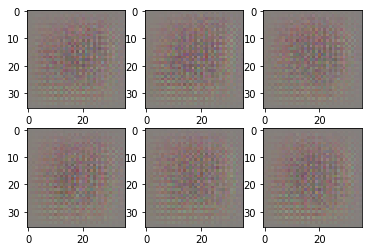

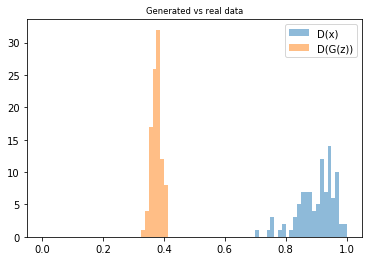

Epoch:  51 disc loss is:  0.696087 gen loss is:  1.03792
Epoch:  52 disc loss is:  0.690805 gen loss is:  1.05548
Epoch:  53 disc loss is:  0.664567 gen loss is:  1.07247
Epoch:  54 disc loss is:  0.668152 gen loss is:  1.08904
Epoch:  55 disc loss is:  0.665653 gen loss is:  1.10606
Epoch:  56 disc loss is:  0.67198 gen loss is:  1.11128
Epoch:  57 disc loss is:  0.656329 gen loss is:  1.11949
Epoch:  58 disc loss is:  0.662319 gen loss is:  1.12449
Epoch:  59 disc loss is:  0.67806 gen loss is:  1.12565
Epoch:  60 disc loss is:  0.705188 gen loss is:  1.101
Epoch:  61 disc loss is:  0.694524 gen loss is:  1.11128
Epoch:  62 disc loss is:  0.711932 gen loss is:  1.10936
Epoch:  63 disc loss is:  0.706593 gen loss is:  1.10821
Epoch:  64 disc loss is:  0.726602 gen loss is:  1.09166
Epoch:  65 disc loss is:  0.714507 gen loss is:  1.1229
Epoch:  66 disc loss is:  0.705901 gen loss is:  1.13308
Epoch:  67 disc loss is:  0.698726 gen loss is:  1.13552
Epoch:  68 disc loss is:  0.712946 g

In [ ]:
from IPython import display
#from tqdm import tnrange

for epoch in range(10000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    if gen_loss<5:
        if disc_loss>1:
            for i in range(5):
                s.run(disc_optimizer,feed_dict)
        elif disc_loss>0.2:
            for i in range(4):
                s.run(disc_optimizer,feed_dict)
        else:
            for i in range(3):
                s.run(disc_optimizer,feed_dict)
    if gen_loss<2:
        disc_loss,gen_loss,_=s.run([d_loss,g_loss,gen_optimizer],feed_dict)
    else:
        s.run(gen_optimizer,feed_dict)
        disc_loss,gen_loss,_=s.run([d_loss,g_loss,gen_optimizer],feed_dict)
    print("Epoch: ",epoch,"disc loss is: ",disc_loss,"gen loss is: ",gen_loss)
    
    if epoch %50==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(100)
        if epoch>259 and ((gen_loss<1.3*best_loss and gen_loss<4) or gen_loss<1.5):
            generator.save_weights("best_weights.h5")
            best_loss=gen_loss
        if gen_loss>4.9:
            generator.load_weights("best_weights.h5")

In [15]:
hid_layers=[]
for layer_idx in range(len(generator.layers)):
    if isinstance(generator.layers[layer_idx], L.Conv2DTranspose) or isinstance(generator.layers[layer_idx], L.Dense):
        hid_layers.append(K.function([generator.layers[0].input],[generator.layers[layer_idx].output]))    
inp=np.random.normal(size=(1, 256)).astype('float32')

for layer in hid_layers:
    print(layer([inp])[0][0][0])
    break

1.38378


In [31]:
for layer_idx in range(len(generator.layers)):
    if isinstance(generator.layers[layer_idx], L.Conv2DTranspose) or isinstance(generator.layers[layer_idx], L.Dense):
        print(generator.layers[layer_idx].name,generator.layers[layer_idx].get_weights()[0])
        break

dense_4 [[ 0.11976485 -0.15142457 -0.03225405 ...,  0.10701916  0.05275875
   0.09462477]
 [-0.16640402 -0.01036905 -0.0361917  ..., -0.02111582 -0.02778634
   0.07793108]
 [ 0.00608962  0.12819652  0.01561431 ...,  0.1098655   0.11078729
   0.07232697]
 ..., 
 [ 0.11864123 -0.00767244 -0.14137456 ..., -0.03611277 -0.03365749
  -0.04518607]
 [ 0.03221026  0.11773942  0.05349169 ...,  0.11291595 -0.00597975
  -0.10518932]
 [ 0.10179421  0.01810044 -0.03679198 ..., -0.04899525 -0.02438601
   0.16945009]]


In [32]:
for layer_idx in range(len(generator.layers)):
    if isinstance(generator.layers[layer_idx], L.Conv2DTranspose) or isinstance(generator.layers[layer_idx], L.Dense):
        print(generator.layers[layer_idx].name,generator.layers[layer_idx].get_weights()[0])
        break

dense_4 [[ 0.11976485 -0.15142457 -0.03225405 ...,  0.10701916  0.05275875
   0.09462477]
 [-0.16640402 -0.01036905 -0.0361917  ..., -0.02111582 -0.02778634
   0.07793108]
 [ 0.00608962  0.12819652  0.01561431 ...,  0.1098655   0.11078729
   0.07232697]
 ..., 
 [ 0.11864123 -0.00767244 -0.14137456 ..., -0.03611277 -0.03365749
  -0.04518607]
 [ 0.03221026  0.11773942  0.05349169 ...,  0.11291595 -0.00597975
  -0.10518932]
 [ 0.10179421  0.01810044 -0.03679198 ..., -0.04899525 -0.02438601
   0.16945009]]


In [49]:
from submit_honor import submit_honor
submit_honor((generator, discriminator),'ndev@nd.edu','jfkafvXmaEaAa4ez')

Submitted to Coursera platform. See results on assignment page!


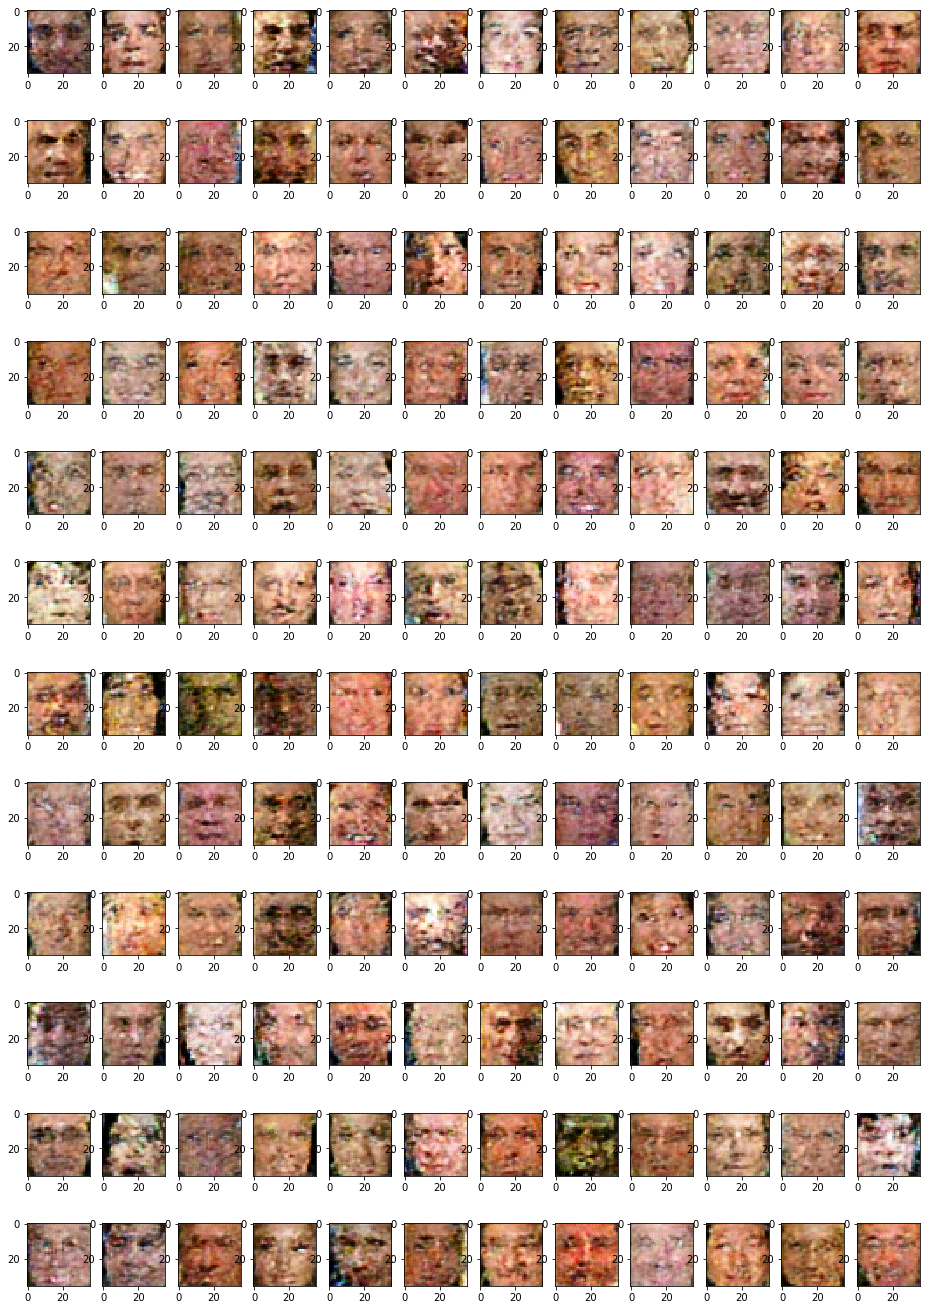

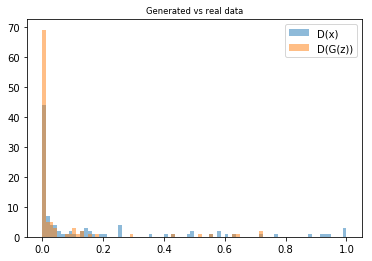

In [58]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(12,12)
sample_probas(100)